# Problem C: Prediction of Traffic Flow based on Burgers’ Equation Model
Burgers' equation is a mathematical model used in various fields, including traffic flow, to represent the behavior of nonlinear systems with both convective and diffusive effects. In traffic flow, it captures the interactions between vehicles, such as the tendency for traffic to slow down when density increases (convection) and the tendency for traffic to spread out due to individual driver behavior (diffusion). 

The Burger's Equation for modeling traffic flow is given as follows:
\begin{equation}
u_t + uu_x = \nu u_{xx}, \quad x\in (-1,1),\ t\in(0,1] 
\end{equation}
Where:
- $u(x,t)$: car velocity (m/s),
- $\nu$: a diffusion coefficient (reflecting how drivers respond to nearby traffic; higher $\nu$ = more cautious drivers),
- $x$: position along the road,
- $t$: time.

We set $\nu=0.1$ and consider the Dirichlet boundary condition, i.e.:
$$
u(x=-1, t) = u(x=1, t)=0,\quad t\in(0,1]
$$

With this PDE model, once the initial velocity field $u(x,t=0)=a(x)$ is given, we can predict the velocity field $u(x,t)$ at any time $t>0$ by solving Burger's equation.

## Task: predicting the velocity filed $u(x,t)$ given the inital field $u(x,t=0)=a(x)$ 
In this task, we have collected many initial field $u(x,t=0)=a(x)$ which are sampled from a distribution $\mathcal{A}$. We have also computed the corresponding velocity field $u(x,t)$ by solving Burger's equation with a high-precision FDM method. Now, we hope to make a fast prediction of the velocity field $u(x,t)$ once a new initial condition $a(x)$ is given from the same distribution.

### The goals
- Please select a suitable deep learning method for solving this task, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve (and report the final error). The $L^2$ relative error between the prediction $\{u^{(j)}_{pred}\}^{N}_{j}$ and the truth $\{u^{(j)}_{true}\}^{N}_j$ is defined as follows:
  $$error = \frac{1}{N}\sum_j\sqrt{\frac{\sum_i|u^{(j)}_{pred}(x_i, t_i)-u^{(j)}_{true}(x_i,t_i)|^2}{\sum_i|u^{(j)}_{true}(x_i, t_i)|^2}}$$
 where $j$ indicates the $j$-th instance.
- Plot the initial field, the corresponding predicted solution (and the ground truth reference), and the pointwise absolute error for the first instance in the testing Dataset using separate figures with ```matplotlib```.

### Dataset
The observation and the ground truth references are given in the dataset ```TrafficFlow.h5```:
- ```a_train```: size(1000, 128), the collected $N=1000$ initial fields (on $128$ sensors)
- ```u_train```: size(1000, 100, 128), the collected $N=1000$ velocity fields (on $100\times 128$ temporal-spatial regular meshgrids)
- ```a_test```: size(200, 128), the initial fields that we are going to predict their corresponding velocity field (Should not be used for training)
- ```u_test```: size(200, 100, 128), the ground truth reference of the velocity field (Should not be used for training)
- ```x_mesh```: size(128, 1), the spatial-coordiante of locations where the velocity field computed
- ```t_mesh```: size(100, 1), the temporal-coordiante of locations where the velocity field computed
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/dno4pdes](https://www.kaggle.com/datasets/yhzang32/dno4pdes)

**Download Dataset**

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yhzang32/dno4pdes")

print("Path to dataset files:", path)

c:\Users\denni\miniconda3\envs\deep_learning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\denni\.cache\kagglehub\datasets\yhzang32\dno4pdes\versions\8


**Set Up Dataset Locally - Training & Testing**

Keys in the dataset: ['a_test', 'a_train', 't_mesh', 'u_test', 'u_train', 'x_mesh']
ax_train shape: torch.Size([1000, 128, 2])
uT_train shape: torch.Size([1000, 128, 1])
gridx shape: torch.Size([128, 1])


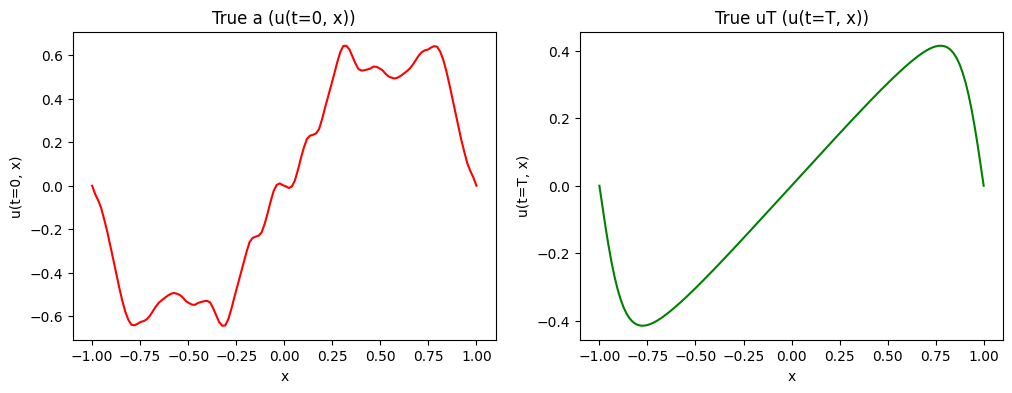

In [3]:
import numpy as np
import h5py
import torch
import os
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32


traffic_flow_dataset = os.path.join(path, 'TrafficFlow.h5') 

######################################
# Load training data
######################################
######################################
# Load training data
######################################
data = h5py.File(traffic_flow_dataset, "r")
print("Keys in the dataset:", list(data.keys()))

def get_data(a_data, u_data, x_data, dtype):
    a = torch.tensor(np.array(a_data), dtype=dtype)
    u = torch.tensor(np.array(u_data), dtype=dtype)
    uT = u[:, -1, :]
    gridx = torch.tensor(np.array(x_data), dtype=dtype)
    #
    uT = uT.reshape(uT.shape[0], -1, 1)
    ax = torch.cat([a.reshape(a.shape[0], -1, 1), gridx.repeat(a.shape[0], 1, 1)], dim=-1)
    return ax, uT, gridx

t_mesh = torch.tensor(np.array(data['t_mesh']), dtype=dtype)
ax_train, uT_train, gridx = get_data(data['a_train'], data['u_train'], data['x_mesh'], dtype)
print('ax_train shape:', ax_train.shape)
print('uT_train shape:', uT_train.shape)
print('gridx shape:', gridx.shape)
# ax_test, uT_test, gridx = get_data(data['a_test'], data['u_test'], data['x_mesh'], dtype)

######################################
# Visualize training data
######################################
a_show, uT_show = ax_train[0,:,0], uT_train[0]
#
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
#
axs.flat[:][0].plot(gridx.flatten(), a_show.flatten(), color='r')
axs.flat[:][0].set_title('True a (u(t=0, x))')
axs.flat[:][0].set_xlabel('x')
axs.flat[:][0].set_ylabel('u(t=0, x)')
#
axs.flat[:][1].plot(gridx.flatten(), uT_show.flatten(), color='green')
axs.flat[:][1].set_title('True uT (u(t=T, x))')
axs.flat[:][1].set_xlabel('x')
axs.flat[:][1].set_ylabel('u(t=T, x)')
#
plt.show()

**FNO Architecture**

In [4]:
import torch.nn as nn

class SpectralConv1d(nn.Module):
    
    def __init__(self, in_size, out_size, modes, dtype):
        super(SpectralConv1d, self).__init__()
        '''1D Fourier layer: FFT -> linear transform -> Inverse FFT
        '''
        self.in_size = in_size 
        self.out_size = out_size 
        self.modes = modes
        #
        self.scale = 1./(in_size * out_size)
        #
        if (dtype is None) or (dtype==torch.float32):
            ctype = torch.complex64 
        elif (dtype==torch.float64):
            ctype = torch.complex128 
        else:
            raise TypeError(f'No such data type.')
        #
        self.weight = nn.Parameter(self.scale * torch.rand(in_size, out_size, 
                                                           self.modes, dtype=ctype))
    
    def compl_mul_1d(self, input, weights):
        '''Complex multiplication: (batch_size, in_size, m) , (in_size, out_size, m) -> (batch_size, out_size, m)
        '''
        return torch.einsum("bim, iom->bom", input, weights)

    def forward(self, x):
        '''
        Input: 
            x: size(batch_size, in_size, mesh_size)
        '''
        batch_size = x.shape[0]
        ######## Compute Fourier coefficients up to factor of e^{-c}
        x_ft = torch.fft.rfft(x)  # size (batch_size, in_size, mesh_size//2+1)
        ######## Multiply relevant Fourier modes
        out_ft = torch.zeros(batch_size, self.out_size, x.size(-1)//2+1, 
                             device=x.device, dtype=torch.cfloat)
        out_ft[:,:,:self.modes] = self.compl_mul_1d(x_ft[:,:,:self.modes], self.weight)
        ######## Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1)) # size(batch_size, out_size, mesh_size)

        return x
        
class FNO1d(nn.Module):

    def __init__(self, in_size:int, out_size:int, modes:int, hidden_list:list[int], dtype=None):
        super(FNO1d, self).__init__()
        self.hidden_list = hidden_list
        # Activation
        self.activation = nn.ReLU()
        # The input layer: 
        self.fc_in = nn.Linear(in_size, hidden_list[0], dtype=dtype)
        # The hidden layer
        conv_net, w_net = [], []
        self.hidden_in = hidden_list[0]
        for hidden in hidden_list:
            conv_net.append(SpectralConv1d(self.hidden_in, hidden, modes, dtype))
            w_net.append(nn.Conv1d(self.hidden_in, hidden, 1, dtype=dtype))
            self.hidden_in =  hidden 
        self.spectral_conv = nn.Sequential(*conv_net)
        self.weight_conv = nn.Sequential(*w_net)
        # The output layer
        self.fc_out0 = nn.Linear(self.hidden_in, 128, dtype=dtype)
        self.fc_out1 = nn.Linear(128, out_size, dtype=dtype)
    
    def forward(self, ax):
        '''
        Input: 
            ax: size(batch_size, my_size, mx_size, a_size+x_size)
        Output: 
            u: size(batch_size, my_size, mx_size, out_size)
        '''
        batch_size = ax.shape[0]
        # The input layer: size(b, mesh_size, in_size) -> (b, in_size, mesh_size)
        ax = self.fc_in(ax)
        ax = ax.permute(0, 2, 1)
        # The spectral conv layer 
        for conv, weight in zip(self.spectral_conv, self.weight_conv):
            ax1 = conv(ax)
            ax2 = weight(ax)
            ax = self.activation(ax1+ax2)
        # The output layer: size(b, hidden, mesh_size) -> (b, mesh_size, out_size)
        ax = ax.permute(0, 2, 1)
        ax = self.fc_out0(ax)
        ax = self.activation(ax)
        
        return self.fc_out1(ax)
#
modes = 16
hidden_list = [40, 40, 40]
model_uT = FNO1d(ax_train.shape[-1], uT_train.shape[-1], modes, hidden_list).to(device)

**Loss Function Definition**

In [5]:
class LossClass(object):

    def __init__(self, uT_model):
        self.device = device
        self.uT_model = uT_model 
    
    def loss_data(self, ax_batch, uT_batch):
        '''loss term'''
        batch_size = uT_batch.shape[0]
        ax, uT = ax_batch.to(self.device), uT_batch.to(self.device)
        #
        uT_pred = self.uT_model(ax)
        loss = torch.norm(uT.reshape(batch_size, -1)-uT_pred.reshape(batch_size, -1), 2, 1)
        loss = torch.mean(loss)
        
        return loss 

**Training**

In [42]:
from tqdm import trange
from torch.utils.data import Dataset, DataLoader
import time
############# Define your own dataset 
class MyDataset(Dataset):

    def __init__(self, ax:torch.tensor, uT:torch.tensor):
        '''
        Input:
            ax: size(batch_size, a_size)
            uT: size(batch_size, uT_size)
        '''
        self.ax = ax
        self.uT = uT
    
    def __getitem__(self, index):
        return self.ax[index], self.uT[index]

    def __len__(self):
        return self.ax.shape[0]
        
train_loader = DataLoader(MyDataset(ax_train, uT_train), batch_size=50, shuffle=True)

################# Training setups
epochs = 2000
lr = 1e-3
optimizer = torch.optim.Adam(params=model_uT.parameters(), lr=lr, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/5), gamma=0.5)
loss_list = []
t0 = time.time()
for epoch in trange(epochs):
    loss = 0.
    for ax_batch, uT_batch in train_loader:
        lossClass = LossClass(model_uT)
        loss_train = lossClass.loss_data(ax_batch, uT_batch)
        #
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        #
        loss += loss_train
    #
    scheduler.step()  # Adjust learning rate
    #
    loss = loss/len(train_loader)
    loss_list.append(loss.item())
    if (epoch+1)%400==0:
        print(f'Epoch:{epoch}, The loss is:{loss.item()}')
print('The consuming time is:', time.time()-t0)
torch.save(model_uT.state_dict(), 'model_uT.pth')
print("Model weights saved successfully.")

 20%|██        | 401/2000 [00:51<03:02,  8.75it/s]

Epoch:399, The loss is:0.019448114559054375


 40%|████      | 801/2000 [01:39<02:46,  7.19it/s]

Epoch:799, The loss is:0.013777481392025948


 60%|██████    | 1201/2000 [02:33<01:35,  8.32it/s]

Epoch:1199, The loss is:0.007311317604035139


 80%|████████  | 1601/2000 [03:23<00:51,  7.82it/s]

Epoch:1599, The loss is:0.004619595594704151


100%|██████████| 2000/2000 [04:11<00:00,  7.94it/s]

Epoch:1999, The loss is:0.004423529375344515
The consuming time is: 251.80102133750916
Model weights saved successfully.


**Testing**

The shape of ax_test: torch.Size([200, 128, 2])
The shape of uT_test: torch.Size([200, 128, 1])
The shape of x_test: torch.Size([128, 1])
The shape of uT_pred: torch.Size([200, 128, 1])
The average l2 error: tensor(0.0029)


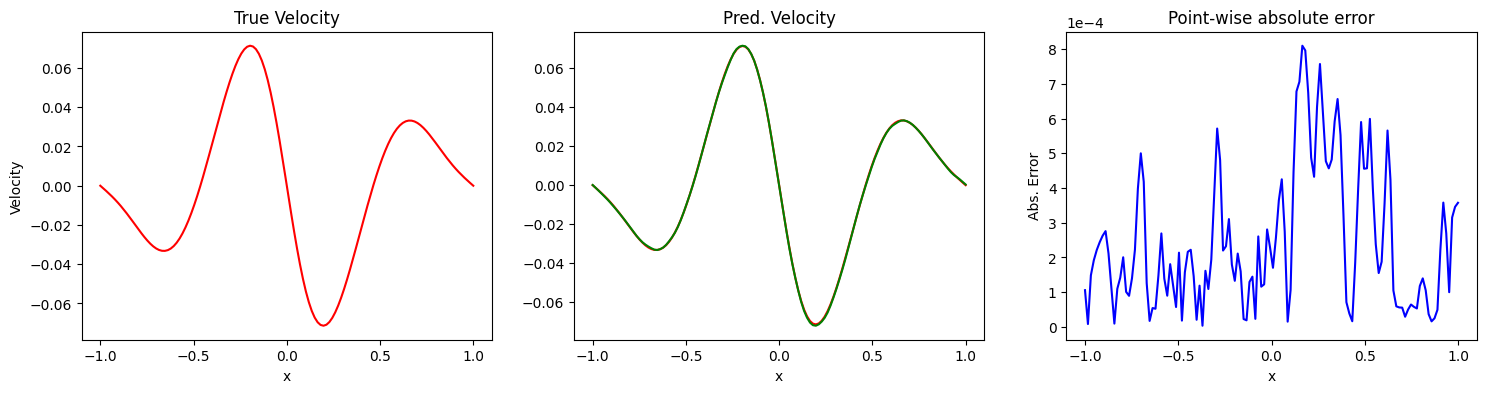

In [6]:
from matplotlib.ticker import MaxNLocator
######################################
# Load testing data
######################################
#
ax_test, uT_test, x_test = get_data(data['a_test'], data['u_test'], data['x_mesh'], dtype)
print('The shape of ax_test:', ax_test.shape)
print('The shape of uT_test:', uT_test.shape)
print('The shape of x_test:', x_test.shape)
#######################################
# The L2 relative error
#######################################
def L2_error(uT, uT_pred):
    ''' '''
    ndata = uT.shape[0]
    l2 = torch.norm(uT.reshape(ndata,-1)-uT_pred.reshape(ndata,-1), 2, 1) / torch.norm(uT.reshape(ndata,-1), 2, 1)
    return l2
# Make prediction with trained model

modes = 16
hidden_list = [40, 40, 40]
model_uT = FNO1d(ax_train.shape[-1], uT_train.shape[-1], modes, hidden_list).to(device)
model_uT.load_state_dict(torch.load('model_uT.pth', weights_only=True))
model_uT.eval()

uT_test_pred = model_uT(ax_test.to(device)).detach().cpu()
print('The shape of uT_pred:', uT_test_pred.shape)
# compute the L2 relative error
l2_err = L2_error(uT_test, uT_test_pred)
print('The average l2 error:', torch.mean(l2_err))
#######################################
# Visualize the prediction and truth u
#######################################
inx = 0
uT_true, uT_pred = uT_test[inx], uT_test_pred[inx]
#
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
#
axs.flat[:][0].plot(x_test.flatten(), uT_true.flatten(), color='r')
axs.flat[:][0].set_title('True Velocity')
axs.flat[:][0].set_xlabel('x')
axs.flat[:][0].set_ylabel('Velocity')
#
axs.flat[:][1].plot(x_test.flatten(), uT_true.flatten(), color='r', label='True')
axs.flat[:][1].plot(x_test.flatten(), uT_pred.flatten(), color='green', label='Pred')
axs.flat[:][1].set_title('Pred. Velocity')
axs.flat[:][1].set_xlabel('x')
#
abs_error = torch.abs(uT_true - uT_pred)
axs.flat[:][2].plot(x_test.flatten(), abs_error.flatten(), color='blue')
axs.flat[:][2].set_title('Point-wise absolute error')
axs.flat[:][2].set_xlabel('x')
axs.flat[:][2].set_ylabel('Abs. Error')
axs.flat[:][2].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

for ax in axs.flat:
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5))

plt.show()